In [1]:
packages<- c(
"dplyr",
"readr",
"tidyr",
"purrr",
"broom",
"magrittr",
"corrplot",
"caret",
"rpart",
"rpart.plot",
"e1071",
"torch",
"luz",
"ramify",
"keras"
)
sapply(packages, require, character.only=T)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: readr

Loading required package: tidyr

Loading required package: purrr

Loading required package: broom

Loading required package: magrittr


Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract


Loading required package: corrplot

corrplot 0.92 loaded

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Loading required package: rpart

Loading required package: rpart.plot

Loading required package: e1071

Loading required package: torch

Loading required package: luz

Loa

dplyr      readr      tidyr      purrr      broom   magrittr   corrplot 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
     caret      rpart rpart.plot      e1071      torch        luz     ramify 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE      FALSE 
     keras 
     FALSE

[1] 400 784

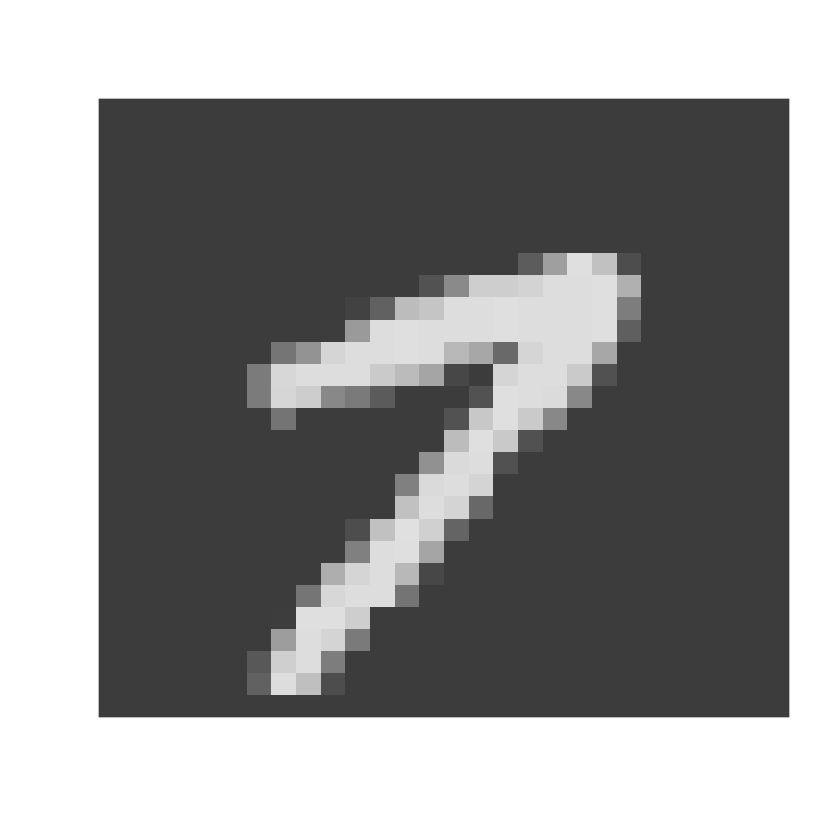

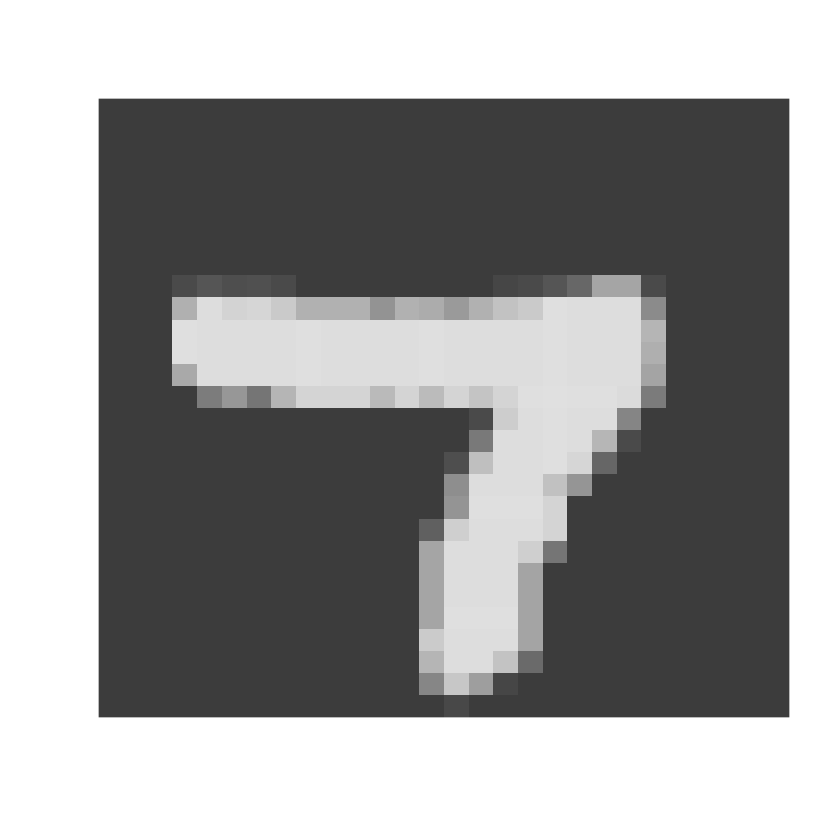

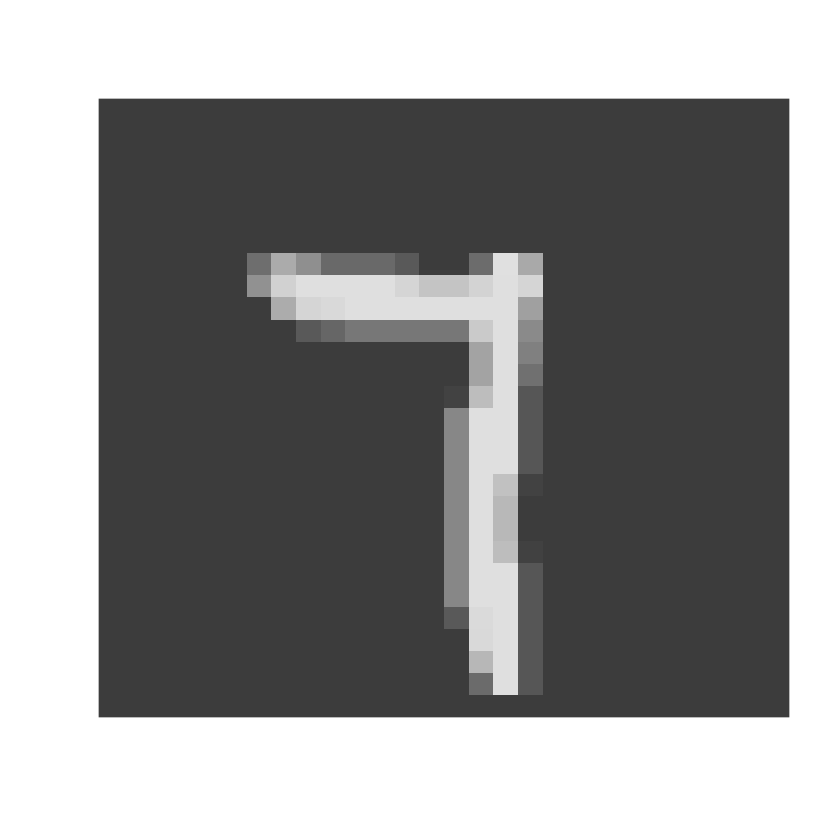

In [33]:
library(tidyverse)
data = read.csv("image_data.csv",header = F)
dim(data)
change = lapply(asplit(data, 1), matrix, nrow= 28)
image(change[[7]][,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
image(change[[45]][,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
image(change[[90]][,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )


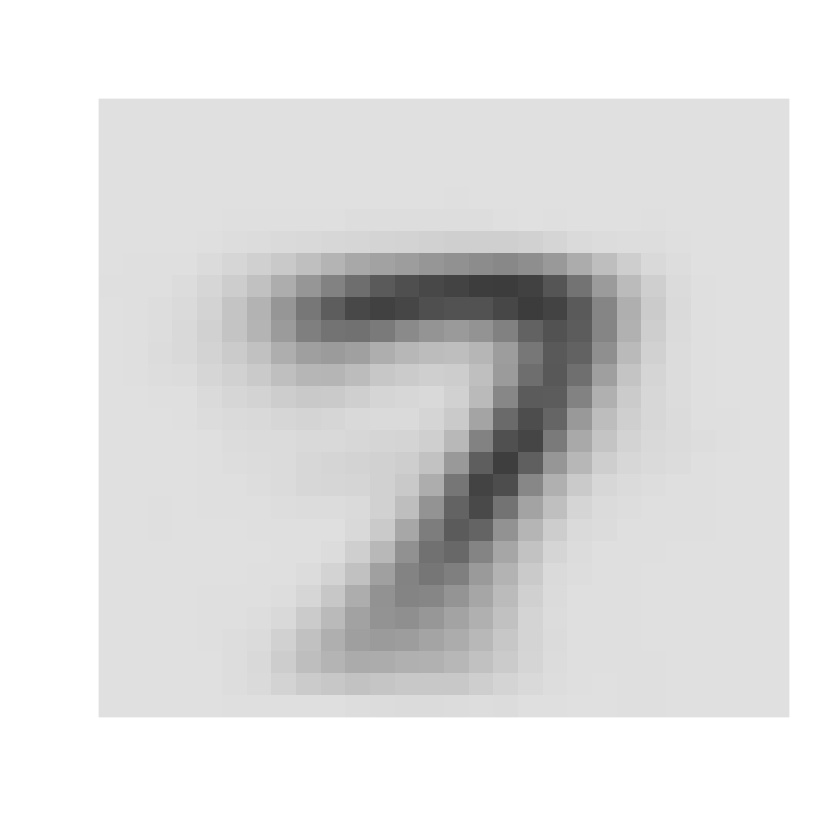

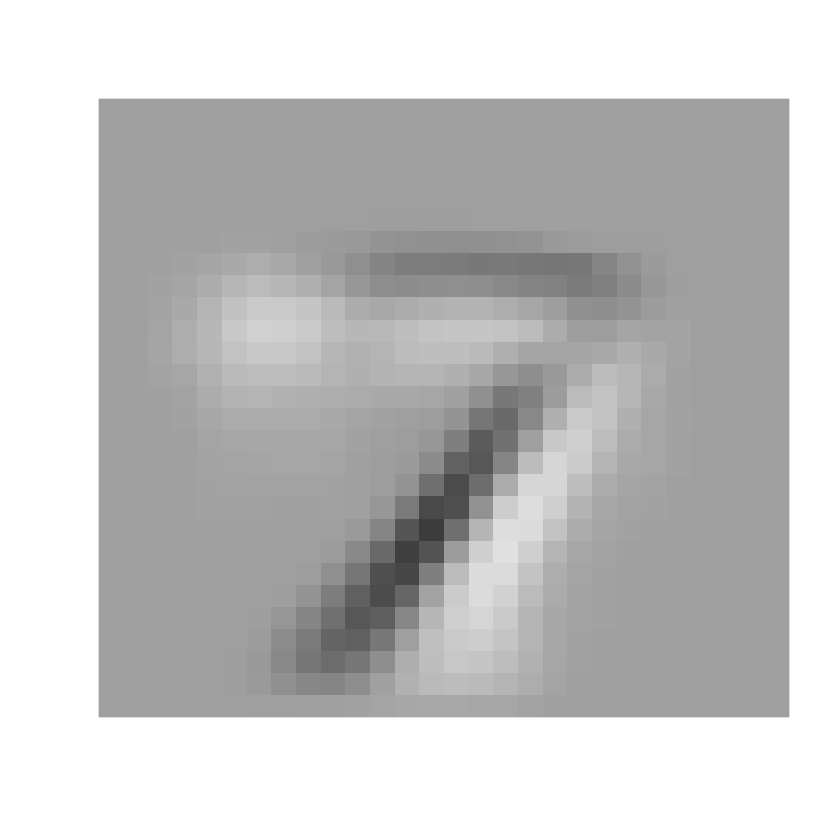

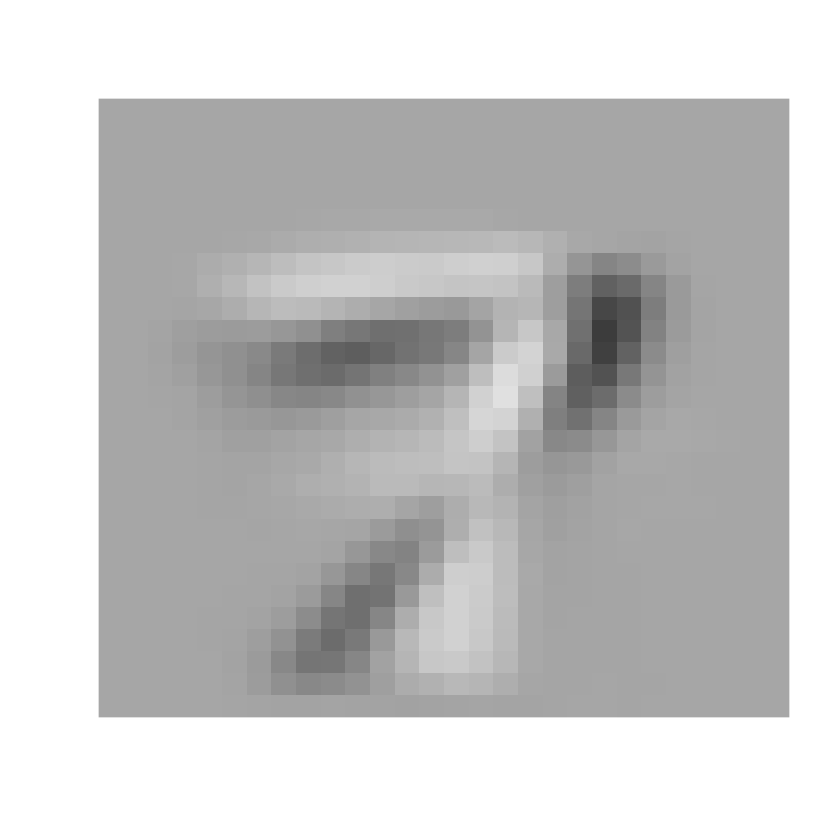

In [15]:
# PCA xTx 
# data n * p 
# xtx - > p * p
# xxt - > n * n
xtx = crossprod(as.matrix(data)) * 1/784
ev = eigen(xtx)
for (i in 1:3){
    evi = ev$vectors[, i] %>% matrix(nrow = 28)
    image(evi[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
}


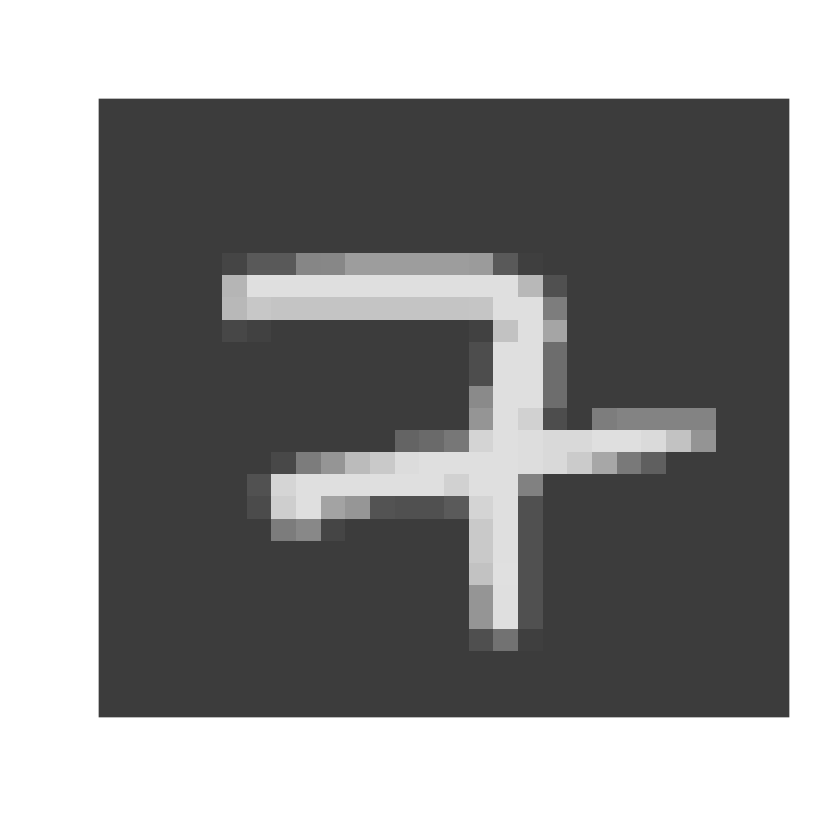

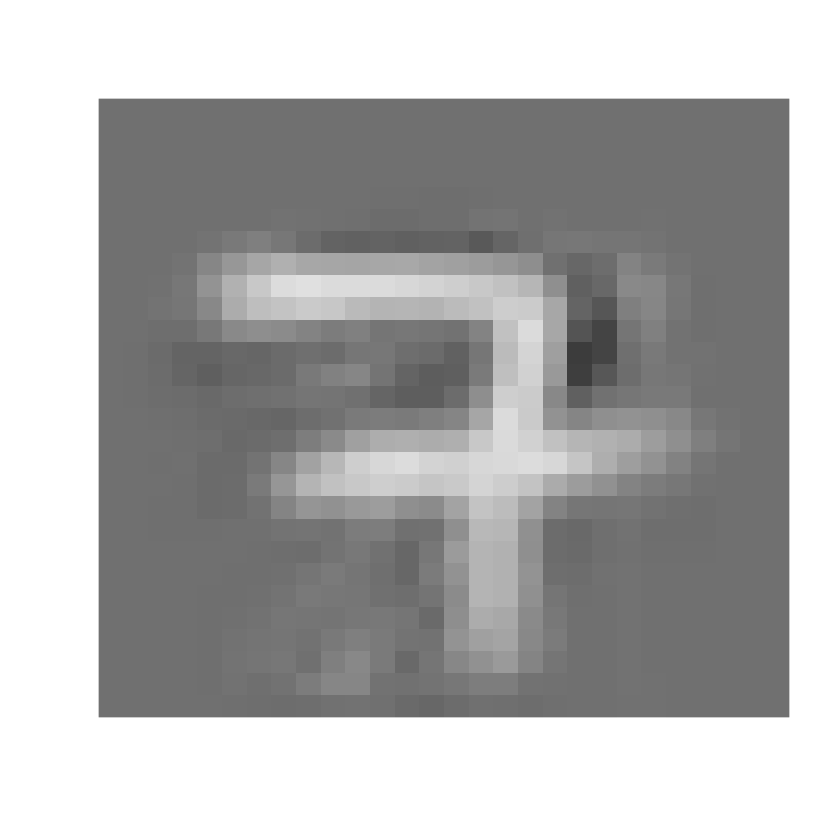

In [35]:
pca = prcomp(data)
evector25 = pca$rotation[,1:25]
dat1 = crossprod(as.matrix(data[1,]) %>% t(), evector25)

mean784 = colMeans(data) 
ge = crossprod(evector25 %>% t, pca$x[, 1:25] %>% t)
recon = apply(ge,2, \(x) x+mean784) %>% t
image(change[[3]][,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
image((recon[3,]%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )



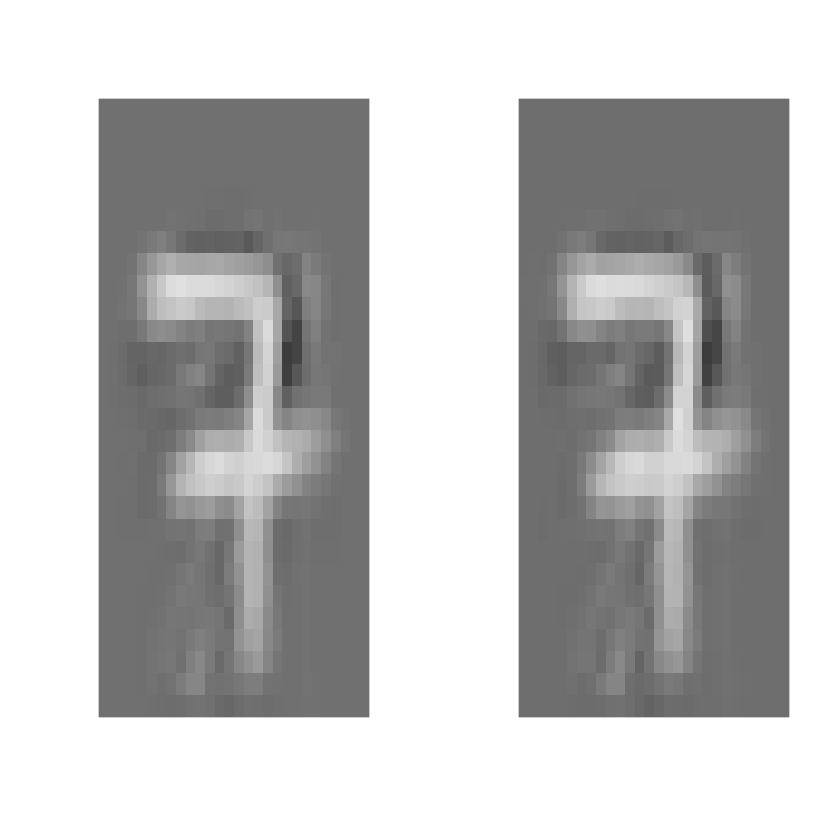

In [45]:
# xtx - > p * p 
# pca = prcomp(data)
# evector25 = pca$rotation[,1:25]
# dat1 = crossprod(as.matrix(data[1,]) %>% t(), evector25)

# mean784 = colMeans(data) 
# ge = crossprod(evector25 %>% t, pca$x[, 1:25] %>% t)
# recon = apply(ge,2, \(x) x+mean784) %>% t
# image(change[[3]][,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
# image((recon[3,]%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )

# xxt - > n*n 400 * 400
newdata = t(data)
pca.2 = prcomp(newdata)
evector25.2 = pca.2$rotation[,1:25]

par(mfrow= c(1,2))
mean784.2 = colMeans(newdata) 
ge.2 = crossprod(evector25.2 %>% t, pca.2$x[, 1:25] %>% t)
recon.2 = apply(ge.2, 2, \(x) x+mean784.2)
image((recon[3,]%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
image((recon.2[3,]%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) ) # t(data) xxt

